## `분석주제`

### Import

In [1]:
import numpy as np
import pandas as pd
# preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error
# modeling
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# visualize
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

C:\Users\inuya\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read Data

In [4]:
train = pd.read_csv('../data/train.csv', parse_dates=['base_date'], dtype={'maximum_speed_limit':int})
test = pd.read_csv('../data/test.csv', parse_dates=['base_date'], dtype={'maximum_speed_limit':int})
sample = pd.read_csv('../data/sample_submission.csv')

### 1. EDA

## 2. Data Cleansing

#### [Drop] categorical variable
특정값이 많은 변수는 데이터를 잘 설명하지 못한다. 변수 내 범주빈도를 구한 뒤 가장 큰 범주빈도가 0.95 이상이면 제거한다.

In [5]:
category = ['road_rating', 'road_name', 'multi_linked', 'connect_code', 'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
            'height_restricted', 'road_type', 'start_node_name','start_turn_restricted', 'end_node_name','end_turn_restricted']

In [6]:
category_dense = train[category].apply(lambda x: x.value_counts(normalize=True).iloc[0])

print(f'삭제되는 열은 {category_dense[category_dense > 0.95].index.values} 입니다.')
train.drop(category_dense[category_dense > 0.95].index, axis=1, inplace=True)
test.drop(category_dense[category_dense > 0.95].index, axis=1, inplace=True)

삭제되는 열은 ['multi_linked' 'connect_code' 'vehicle_restricted' 'height_restricted'] 입니다.


#### [Imputation] road name
'-'는 결측치이다. 출발지점과 도착지점을 정렬한 후 가까운 값으로 대치한다.

In [7]:
replace = train.sort_values(['start_latitude', 'start_longitude', 'end_latitude','end_longitude'])[['id','road_name']]
fb = replace['road_name'].apply(lambda x: np.nan if x=='-' else x).fillna(method='ffill').fillna(method='backfill')
bf = replace['road_name'].apply(lambda x: np.nan if x=='-' else x).fillna(method='backfill').fillna(method='ffill')

print('ffill 후 backfill하는 방법의 차이:', (train.query('road_name != "-"').road_name.value_counts(normalize=True)\
                                             - fb.value_counts(normalize=True)).std())
print('backfill 후 ffill하는 방법의 차이:', (train.query('road_name != "-"').road_name.value_counts(normalize=True)\
                                             - bf.value_counts(normalize=True)).std())

ffill 후 backfill하는 방법의 차이: 0.0029825077021651365
backfill 후 ffill하는 방법의 차이: 0.002328224428765971


In [8]:
train['road_name'] = bf
test['road_name'] = test['road_name'].apply(lambda x: np.nan if x=='-' else x).fillna(method='backfill').fillna(method='ffill')

#### [Labeling] noad name
입구, 교, 교차로/사거리/삼거리, 주택/아파트, 기타로 특성을 구분한다.

In [9]:
# 보류

#### [Labeling] node name
node name을 labeling하고 이로써 출발지점, 도착지점의 방향을 고려한 labeling을 시도한다.

In [10]:
# 출발과 도착이 같은 edge_label은 0으로 통일하는 등의 방법도 고려해봄
# print('start=end train:', train.query('start_node_name == end_node_name').shape[0]/train.shape[0])
# print('start=end test:', test.query('start_node_name == end_node_name').shape[0]/test.shape[0])

In [11]:
label_df = pd.concat([train['start_node_name'].rename('node_name'), train['end_node_name'].rename('node_name')]).drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'node_label'}).set_index('node_name')

for label in pd.concat([test['start_node_name'].rename('node_name'), test['end_node_name'].rename('node_name')]).drop_duplicates():
    if label not in label_df.index:
        label_df.loc[label] = label_df['node_label'].max() + 1

In [12]:
train['start_node_label'] = pd.merge(train[['id','start_node_name']], 
                                     label_df.reset_index().rename(columns={'node_name':'start_node_name'}), 
                                     on='start_node_name', how='left')['node_label']
train['end_node_label'] = pd.merge(train[['id','end_node_name']], 
                                   label_df.reset_index().rename(columns={'node_name':'end_node_name'}), 
                                   on='end_node_name', how='left')['node_label']

In [13]:
test['start_node_label'] = pd.merge(test[['id','start_node_name']], 
                                     label_df.reset_index().rename(columns={'node_name':'start_node_name'}), 
                                     on='start_node_name', how='left')['node_label']
test['end_node_label'] = pd.merge(test[['id','end_node_name']], 
                                   label_df.reset_index().rename(columns={'node_name':'end_node_name'}), 
                                   on='end_node_name', how='left')['node_label']

In [14]:
del train['start_node_name'], train['end_node_name']
del test['start_node_name'], test['end_node_name']

#### [Labeling] edge

In [15]:
label_df = train[['start_node_label','end_node_label']].drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'edge_label'}).set_index(['start_node_label','end_node_label'])

for label in test[['start_node_label','end_node_label']].drop_duplicates().values:
    if tuple(label) not in label_df.index:
        label_df.loc[tuple(label), 'edge_label'] = label_df['edge_label'].max()+1

In [16]:
train['edge_label'] = pd.merge(train[['id','start_node_label','end_node_label']], label_df.reset_index(), 
                               on=['start_node_label','end_node_label'], how='left')['edge_label']
test['edge_label'] = pd.merge(test[['id','start_node_label','end_node_label']], label_df.reset_index(), 
                               on=['start_node_label','end_node_label'], how='left')['edge_label']

#### [Labeling] latitude, longitude

In [17]:
label_df = train[['start_latitude','start_longitude','end_latitude','end_longitude']].drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'coordinate_label'})\
           .set_index(['start_latitude','start_longitude','end_latitude','end_longitude'])

for label in test[['start_latitude','start_longitude','end_latitude','end_longitude']].drop_duplicates().values:
    if tuple(label) not in label_df.index:
        label_df.loc[tuple(label), 'coordinate_label'] = label_df['coordinate_label'].max()+1  

In [18]:
label_df = label_df.reset_index()

# 방향이 반대인 것은 Minus로 labeling한다.
for IDX, SLAT, SLON, ELAT, ELON, COOR in label_df.itertuples():
    CHANGE = label_df.loc[IDX:].query('(start_latitude==@ELAT) & (start_longitude==@ELON) &\
                                       (end_latitude==@SLAT) & (end_longitude==@SLON)').index
    if len(CHANGE)==1:
        label_df.iloc[CHANGE, -1] = -1 * COOR

In [19]:
train['coor_label'] = pd.merge(train[['id','start_latitude','start_longitude','end_latitude','end_longitude']], label_df, 
                               on=['start_latitude','start_longitude','end_latitude','end_longitude'], how='left')['coordinate_label']
test['coor_label'] = pd.merge(test[['id','start_latitude','start_longitude','end_latitude','end_longitude']], label_df, 
                              on=['start_latitude','start_longitude','end_latitude','end_longitude'], how='left')['coordinate_label']

In [20]:
# # Data Cleansing한 후 저장한다.
# date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
# train.to_csv(f'./data/clean/train_{date}.csv', index=False)
# test.to_csv(f'./data/clean/test_{date}.csv', index=False)

### 3. Feature Engineering

In [21]:
# train = pd.read_csv('./data/clean/train_20221107_1133.csv', parse_dates=['base_date'])
# test = pd.read_csv('./data/clean/test_20221107_1133.csv', parse_dates=['base_date'])

In [22]:
# train의 기간을 조정한다.
train = train.query('base_date >= "2022-06-15"')

In [23]:
feature_train, feature_test = train.copy(), test.copy()

- #### [Generation] 날짜

In [24]:
feature_train['base_month'] = train['base_date'].dt.month
feature_test['base_month'] = test['base_date'].dt.month

In [25]:
feature_train['base_day'] = train['base_date'].dt.day
feature_test['base_day'] = test['base_date'].dt.day

- #### [Generation] 거리, 방위각

In [26]:
# 방위각
def bearing(LAT1, LAT2, LONG1, LONG2):
    lat1, lat2, d_long = map(np.radians, (LAT1, LAT2, LONG2-LONG1))
    y = np.sin(d_long) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_long)
    return np.degrees(np.arctan2(y,x))

In [27]:
feature_train['bearing'] = bearing(train['start_latitude'],train['end_latitude'], train['start_longitude'],train['end_longitude'])
feature_test['bearing'] = bearing(test['start_latitude'],test['end_latitude'], test['start_longitude'],test['end_longitude'])

- #### [Generation] Target Mean

In [28]:
# 평균을 산출할 변수가 1개인 경우
def targetmean_simple(SIMPLE):
    mean_df = train.groupby(SIMPLE)['target'].agg('mean')
    
    for label in np.unique(test[SIMPLE]):
        if label not in mean_df.index:
            # test에 train에 없는 범주가 나온다면 train.target.mean으로 채운다.
            mean_df.loc[label] = train['target'].mean()
    return mean_df

# 평균을 산출할 변수가 여러 개인 경우
def targetmean_multi(*args):
    mean_df = train.groupby(list(args))['target'].agg('mean')
    
    for label in test[list(args)].drop_duplicates().values:
        if tuple(label) not in mean_df.index:
            mean_df.loc[tuple(label)] = train.target.mean()
    return mean_df

In [29]:
mean_df = targetmean_simple('road_name')
feature_train['rn_target'] = feature_train['road_name'].map(mean_df)
feature_test['rn_target'] = feature_test['road_name'].map(mean_df)

In [30]:
mean_df = targetmean_simple('coor_label')
feature_train['coor_target'] = feature_train['coor_label'].map(mean_df)
feature_test['coor_target'] = feature_test['coor_label'].map(mean_df)

- #### [Generation] std

In [31]:
# 표준편차를 산출할 변수가 1개인 경우
def std_simple(SIMPLE):
    std_df = train.groupby(SIMPLE)['target'].agg('std')
    
    for label in np.unique(test[SIMPLE]):
        if label not in std_df.index:
            # test에 train에 없는 범주가 나온다면 train.target.std으로 채운다.
            std_df.loc[label] = train['target'].std()
    return std_df

# 표준편차를 산출할 변수가 여러 개인 경우
# 이 때, 복수의 변수 고려로 데이터가 1개인 범주는 std가 NaN으로 주의해야 한다.
def std_multi(*args):
    std_df = train.groupby(list(args))['target'].agg('std')
    
    for label in test[list(args)].drop_duplicates().values:
        if tuple(label) not in std_df.index:
            std_df.loc[tuple(label)] = train.target.std()
    return std_df

In [32]:
std_df = std_simple('base_hour')
feature_train['hour_std'] = feature_train['base_hour'].map(std_df)
feature_test['hour_std'] = feature_test['base_hour'].map(std_df)

In [33]:
std_df = std_simple('coor_label')
feature_train['coor_std'] = feature_train['coor_label'].map(std_df)
feature_test['coor_std'] = feature_test['coor_label'].map(std_df)

- #### [Generation] 주시간대, 주시간대 교통량

In [34]:
feature_train['main_hour_edge'] = feature_train['edge_label']\
                                .map(feature_train.groupby('edge_label')['base_hour'].agg(lambda x: x.value_counts().index[0]))
feature_test['main_hour_edge'] = feature_test['edge_label']\
                                .map(feature_test.groupby('edge_label')['base_hour'].agg(lambda x: x.value_counts().index[0]))

In [35]:
feature_train['main_hour_dow'] = feature_train['day_of_week']\
                                .map(feature_train.groupby('day_of_week')['base_hour'].agg(lambda x: x.value_counts().iloc[0]))
feature_test['main_hour_dow'] = feature_test['day_of_week']\
                                .map(feature_test.groupby('day_of_week')['base_hour'].agg(lambda x: x.value_counts().iloc[0]))

- #### [Drop] Unuseful Feature

In [36]:
unuse = ['base_date','road_name','weight_restricted']
feature_train.drop(unuse, axis=1, inplace=True)
feature_test.drop(unuse, axis=1, inplace=True)

- #### [Encoding] Categorical Encoding

In [37]:
cat_encode = ['maximum_speed_limit','road_type', 'road_rating','start_node_label','end_node_label', 'edge_label', 'coor_label'] 
cat_uncode = ['day_of_week', 'start_turn_restricted', 'end_turn_restricted']

In [38]:
for i in cat_uncode:
    le = LabelEncoder()
    le = le.fit(feature_train[i])
    feature_train[i]=le.transform(feature_train[i])
    
    for label in np.unique(feature_test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    feature_test[i] = le.transform(feature_test[i])

- #### [Transform] Scaler<br>
  수치형 변수의 분포를 보고 적합한 Scaler를 사용한다.

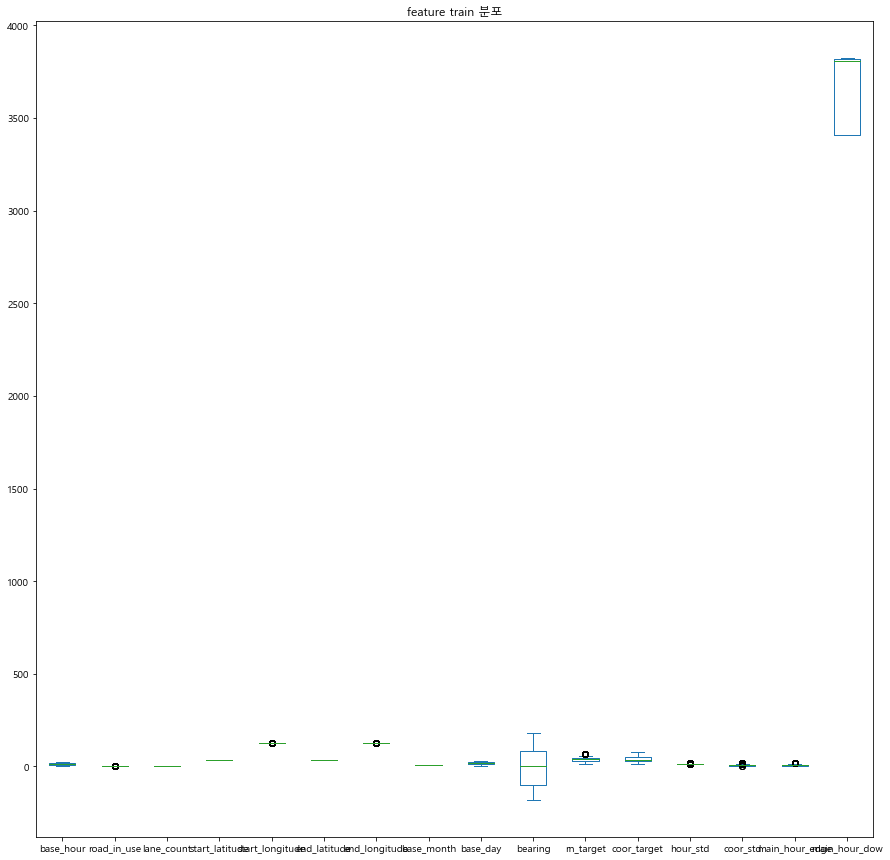

In [39]:
num = [i for i in feature_train.columns if i not in cat_uncode+cat_encode+['id','target']]

feature_train[num].plot.box(title="feature train 분포", figsize=(15,15))
plt.show()

In [40]:
# power, normalizer, robust 등 시도
scaler = PowerTransformer()
feature_train[num] = scaler.fit_transform(feature_train[num])
feature_test[num] = scaler.transform(feature_test[num])

In [41]:
# date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
# feature_train.to_csv(f'./data/feature/train_{date}.csv', index=False)
# feature_test.to_csv(f'./data/feature/test_{date}.csv', index=False)

### y_train

In [48]:
y_train = pd.DataFrame(feature_train['target'])
y_train.to_csv('y_train.csv')

### 4. Modeling

In [42]:
# 기준모델에 input하고 검증할 수 있도록 데이터를 나눈다.
del feature_train['id'], feature_test['id']

y_train = feature_train['target'] ; del feature_train['target']
X_train, X_test = feature_train, feature_test
print('X_train.shape:', X_train.shape, 'X_test.shape', X_test.shape)
print('feature:', X_train.columns)

X_train.shape: (524074, 25) X_test.shape (291241, 25)
feature: Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating',
       'maximum_speed_limit', 'road_type', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_latitude', 'end_longitude',
       'end_turn_restricted', 'start_node_label', 'end_node_label',
       'edge_label', 'coor_label', 'base_month', 'base_day', 'bearing',
       'rn_target', 'coor_target', 'hour_std', 'coor_std', 'main_hour_edge',
       'main_hour_dow'],
      dtype='object')


In [43]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=2022)

- #### LGBM

In [44]:
lgbm_reg = LGBMRegressor(n_estimators=2000, metric= 'mae', random_state = 2022)

In [45]:
fit_params={"early_stopping_rounds":1000, 
            "eval_metric" : 'mae', 
            "eval_set" : [(val_X, val_y)],
            'verbose': 1,
            'categorical_feature': cat_uncode+cat_encode}

In [46]:
lgbm_reg.fit(train_X, train_y, **fit_params)

[1]	valid_0's l1: 11.7861
[2]	valid_0's l1: 10.7527
[3]	valid_0's l1: 9.83951
[4]	valid_0's l1: 9.03248
[5]	valid_0's l1: 8.31275
[6]	valid_0's l1: 7.67865
[7]	valid_0's l1: 7.11525
[8]	valid_0's l1: 6.6194
[9]	valid_0's l1: 6.18616
[10]	valid_0's l1: 5.80451
[11]	valid_0's l1: 5.47625
[12]	valid_0's l1: 5.18465
[13]	valid_0's l1: 4.93485
[14]	valid_0's l1: 4.71701
[15]	valid_0's l1: 4.52687
[16]	valid_0's l1: 4.36624
[17]	valid_0's l1: 4.22672
[18]	valid_0's l1: 4.10577
[19]	valid_0's l1: 4.00049
[20]	valid_0's l1: 3.90871
[21]	valid_0's l1: 3.83005
[22]	valid_0's l1: 3.76156
[23]	valid_0's l1: 3.70273
[24]	valid_0's l1: 3.65038
[25]	valid_0's l1: 3.60564
[26]	valid_0's l1: 3.56431
[27]	valid_0's l1: 3.53242
[28]	valid_0's l1: 3.50289
[29]	valid_0's l1: 3.47672
[30]	valid_0's l1: 3.453
[31]	valid_0's l1: 3.4324
[32]	valid_0's l1: 3.41284
[33]	valid_0's l1: 3.39535
[34]	valid_0's l1: 3.37861
[35]	valid_0's l1: 3.36642
[36]	valid_0's l1: 3.35155
[37]	valid_0's l1: 3.34062
[38]	valid_0's

[323]	valid_0's l1: 2.98062
[324]	valid_0's l1: 2.98041
[325]	valid_0's l1: 2.98015
[326]	valid_0's l1: 2.9799
[327]	valid_0's l1: 2.97971
[328]	valid_0's l1: 2.97952
[329]	valid_0's l1: 2.97949
[330]	valid_0's l1: 2.97942
[331]	valid_0's l1: 2.97885
[332]	valid_0's l1: 2.97867
[333]	valid_0's l1: 2.97852
[334]	valid_0's l1: 2.97842
[335]	valid_0's l1: 2.97824
[336]	valid_0's l1: 2.97813
[337]	valid_0's l1: 2.97806
[338]	valid_0's l1: 2.97798
[339]	valid_0's l1: 2.97788
[340]	valid_0's l1: 2.97786
[341]	valid_0's l1: 2.97779
[342]	valid_0's l1: 2.97773
[343]	valid_0's l1: 2.97753
[344]	valid_0's l1: 2.97752
[345]	valid_0's l1: 2.97737
[346]	valid_0's l1: 2.97735
[347]	valid_0's l1: 2.97682
[348]	valid_0's l1: 2.97675
[349]	valid_0's l1: 2.97678
[350]	valid_0's l1: 2.97642
[351]	valid_0's l1: 2.97634
[352]	valid_0's l1: 2.9763
[353]	valid_0's l1: 2.97617
[354]	valid_0's l1: 2.9761
[355]	valid_0's l1: 2.97602
[356]	valid_0's l1: 2.97592
[357]	valid_0's l1: 2.97586
[358]	valid_0's l1: 2.9

[650]	valid_0's l1: 2.93524
[651]	valid_0's l1: 2.93522
[652]	valid_0's l1: 2.93513
[653]	valid_0's l1: 2.93499
[654]	valid_0's l1: 2.93481
[655]	valid_0's l1: 2.93473
[656]	valid_0's l1: 2.9346
[657]	valid_0's l1: 2.93456
[658]	valid_0's l1: 2.93443
[659]	valid_0's l1: 2.93433
[660]	valid_0's l1: 2.93428
[661]	valid_0's l1: 2.9343
[662]	valid_0's l1: 2.93427
[663]	valid_0's l1: 2.9342
[664]	valid_0's l1: 2.93415
[665]	valid_0's l1: 2.93407
[666]	valid_0's l1: 2.93385
[667]	valid_0's l1: 2.93375
[668]	valid_0's l1: 2.93372
[669]	valid_0's l1: 2.93368
[670]	valid_0's l1: 2.93368
[671]	valid_0's l1: 2.93352
[672]	valid_0's l1: 2.93338
[673]	valid_0's l1: 2.93336
[674]	valid_0's l1: 2.93334
[675]	valid_0's l1: 2.93317
[676]	valid_0's l1: 2.93294
[677]	valid_0's l1: 2.93297
[678]	valid_0's l1: 2.93264
[679]	valid_0's l1: 2.93263
[680]	valid_0's l1: 2.9325
[681]	valid_0's l1: 2.93244
[682]	valid_0's l1: 2.93234
[683]	valid_0's l1: 2.93241
[684]	valid_0's l1: 2.93246
[685]	valid_0's l1: 2.93

[957]	valid_0's l1: 2.9107
[958]	valid_0's l1: 2.91066
[959]	valid_0's l1: 2.91066
[960]	valid_0's l1: 2.91069
[961]	valid_0's l1: 2.91064
[962]	valid_0's l1: 2.91059
[963]	valid_0's l1: 2.91053
[964]	valid_0's l1: 2.9105
[965]	valid_0's l1: 2.9104
[966]	valid_0's l1: 2.91031
[967]	valid_0's l1: 2.91024
[968]	valid_0's l1: 2.9102
[969]	valid_0's l1: 2.91017
[970]	valid_0's l1: 2.91017
[971]	valid_0's l1: 2.91014
[972]	valid_0's l1: 2.91006
[973]	valid_0's l1: 2.90996
[974]	valid_0's l1: 2.90984
[975]	valid_0's l1: 2.90978
[976]	valid_0's l1: 2.90985
[977]	valid_0's l1: 2.9098
[978]	valid_0's l1: 2.90981
[979]	valid_0's l1: 2.9098
[980]	valid_0's l1: 2.90979
[981]	valid_0's l1: 2.90983
[982]	valid_0's l1: 2.90978
[983]	valid_0's l1: 2.90967
[984]	valid_0's l1: 2.90956
[985]	valid_0's l1: 2.90943
[986]	valid_0's l1: 2.90936
[987]	valid_0's l1: 2.90936
[988]	valid_0's l1: 2.90931
[989]	valid_0's l1: 2.90924
[990]	valid_0's l1: 2.9092
[991]	valid_0's l1: 2.90912
[992]	valid_0's l1: 2.90899

[1280]	valid_0's l1: 2.89477
[1281]	valid_0's l1: 2.89475
[1282]	valid_0's l1: 2.89474
[1283]	valid_0's l1: 2.8947
[1284]	valid_0's l1: 2.89469
[1285]	valid_0's l1: 2.89473
[1286]	valid_0's l1: 2.89479
[1287]	valid_0's l1: 2.89478
[1288]	valid_0's l1: 2.89473
[1289]	valid_0's l1: 2.89471
[1290]	valid_0's l1: 2.89468
[1291]	valid_0's l1: 2.89467
[1292]	valid_0's l1: 2.89468
[1293]	valid_0's l1: 2.89467
[1294]	valid_0's l1: 2.89464
[1295]	valid_0's l1: 2.89463
[1296]	valid_0's l1: 2.8947
[1297]	valid_0's l1: 2.89468
[1298]	valid_0's l1: 2.89468
[1299]	valid_0's l1: 2.89463
[1300]	valid_0's l1: 2.89464
[1301]	valid_0's l1: 2.89459
[1302]	valid_0's l1: 2.89453
[1303]	valid_0's l1: 2.89447
[1304]	valid_0's l1: 2.89444
[1305]	valid_0's l1: 2.89443
[1306]	valid_0's l1: 2.89438
[1307]	valid_0's l1: 2.8943
[1308]	valid_0's l1: 2.89435
[1309]	valid_0's l1: 2.89431
[1310]	valid_0's l1: 2.89431
[1311]	valid_0's l1: 2.89429
[1312]	valid_0's l1: 2.89425
[1313]	valid_0's l1: 2.89421
[1314]	valid_0's 

[1598]	valid_0's l1: 2.88454
[1599]	valid_0's l1: 2.88452
[1600]	valid_0's l1: 2.88417
[1601]	valid_0's l1: 2.88411
[1602]	valid_0's l1: 2.88396
[1603]	valid_0's l1: 2.88386
[1604]	valid_0's l1: 2.88381
[1605]	valid_0's l1: 2.8838
[1606]	valid_0's l1: 2.88372
[1607]	valid_0's l1: 2.88361
[1608]	valid_0's l1: 2.88359
[1609]	valid_0's l1: 2.88356
[1610]	valid_0's l1: 2.88348
[1611]	valid_0's l1: 2.88349
[1612]	valid_0's l1: 2.88346
[1613]	valid_0's l1: 2.88333
[1614]	valid_0's l1: 2.8833
[1615]	valid_0's l1: 2.88334
[1616]	valid_0's l1: 2.88334
[1617]	valid_0's l1: 2.88324
[1618]	valid_0's l1: 2.88322
[1619]	valid_0's l1: 2.88312
[1620]	valid_0's l1: 2.88308
[1621]	valid_0's l1: 2.88284
[1622]	valid_0's l1: 2.88283
[1623]	valid_0's l1: 2.88274
[1624]	valid_0's l1: 2.88271
[1625]	valid_0's l1: 2.88266
[1626]	valid_0's l1: 2.88266
[1627]	valid_0's l1: 2.88259
[1628]	valid_0's l1: 2.88258
[1629]	valid_0's l1: 2.88242
[1630]	valid_0's l1: 2.88235
[1631]	valid_0's l1: 2.88231
[1632]	valid_0's

[1913]	valid_0's l1: 2.87209
[1914]	valid_0's l1: 2.87211
[1915]	valid_0's l1: 2.87206
[1916]	valid_0's l1: 2.87202
[1917]	valid_0's l1: 2.87203
[1918]	valid_0's l1: 2.87201
[1919]	valid_0's l1: 2.87197
[1920]	valid_0's l1: 2.87196
[1921]	valid_0's l1: 2.87194
[1922]	valid_0's l1: 2.87189
[1923]	valid_0's l1: 2.87187
[1924]	valid_0's l1: 2.87188
[1925]	valid_0's l1: 2.87188
[1926]	valid_0's l1: 2.87189
[1927]	valid_0's l1: 2.87194
[1928]	valid_0's l1: 2.87191
[1929]	valid_0's l1: 2.8719
[1930]	valid_0's l1: 2.87185
[1931]	valid_0's l1: 2.8718
[1932]	valid_0's l1: 2.87178
[1933]	valid_0's l1: 2.87173
[1934]	valid_0's l1: 2.87176
[1935]	valid_0's l1: 2.87173
[1936]	valid_0's l1: 2.87174
[1937]	valid_0's l1: 2.87175
[1938]	valid_0's l1: 2.87171
[1939]	valid_0's l1: 2.87169
[1940]	valid_0's l1: 2.87164
[1941]	valid_0's l1: 2.87159
[1942]	valid_0's l1: 2.87154
[1943]	valid_0's l1: 2.8716
[1944]	valid_0's l1: 2.87158
[1945]	valid_0's l1: 2.87156
[1946]	valid_0's l1: 2.87154
[1947]	valid_0's 

LGBMRegressor(metric='mae', n_estimators=2000, random_state=2022)

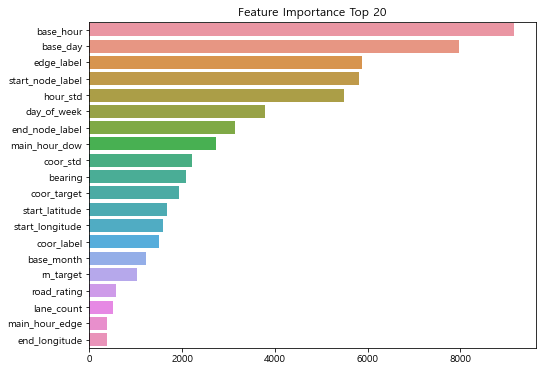

In [47]:
# LGBM의 Feature Importance
ft_importance_values = lgbm_reg.feature_importances_
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

- #### CatBoost

In [48]:
cat_params = {'iterations':2000,
              'eval_metric':'MAE',
              'bootstrap_type':'Bayesian',
              'cat_features': cat_encode+cat_uncode,
              'random_state':2022, 'task_type':"GPU"}

In [17]:
cat_reg = CatBoostRegressor(**cat_params)
cat_reg.fit(train_X, train_y)

Learning rate set to 0.058904


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 12.2335215	total: 39.8ms	remaining: 1m 19s
1:	total: 76ms	remaining: 1m 15s
2:	total: 111ms	remaining: 1m 13s
3:	total: 146ms	remaining: 1m 12s
4:	total: 180ms	remaining: 1m 12s
5:	learn: 9.5905938	total: 216ms	remaining: 1m 11s
6:	total: 253ms	remaining: 1m 11s
7:	total: 288ms	remaining: 1m 11s
8:	total: 324ms	remaining: 1m 11s
9:	total: 359ms	remaining: 1m 11s
10:	learn: 7.6980417	total: 395ms	remaining: 1m 11s
11:	total: 430ms	remaining: 1m 11s
12:	total: 466ms	remaining: 1m 11s
13:	total: 501ms	remaining: 1m 11s
14:	total: 537ms	remaining: 1m 11s
15:	learn: 6.3654936	total: 572ms	remaining: 1m 10s
16:	total: 607ms	remaining: 1m 10s
17:	total: 642ms	remaining: 1m 10s
18:	total: 678ms	remaining: 1m 10s
19:	total: 714ms	remaining: 1m 10s
20:	learn: 5.4553802	total: 750ms	remaining: 1m 10s
21:	total: 785ms	remaining: 1m 10s
22:	total: 820ms	remaining: 1m 10s
23:	total: 855ms	remaining: 1m 10s
24:	total: 891ms	remaining: 1m 10s
25:	learn: 4.8457069	total: 927ms	remaining: 1m 1

216:	total: 7.85s	remaining: 1m 4s
217:	total: 7.88s	remaining: 1m 4s
218:	total: 7.92s	remaining: 1m 4s
219:	total: 7.96s	remaining: 1m 4s
220:	learn: 3.3432007	total: 8s	remaining: 1m 4s
221:	total: 8.03s	remaining: 1m 4s
222:	total: 8.07s	remaining: 1m 4s
223:	total: 8.11s	remaining: 1m 4s
224:	total: 8.14s	remaining: 1m 4s
225:	learn: 3.3401796	total: 8.18s	remaining: 1m 4s
226:	total: 8.21s	remaining: 1m 4s
227:	total: 8.25s	remaining: 1m 4s
228:	total: 8.29s	remaining: 1m 4s
229:	total: 8.32s	remaining: 1m 4s
230:	learn: 3.3371597	total: 8.36s	remaining: 1m 4s
231:	total: 8.4s	remaining: 1m 4s
232:	total: 8.44s	remaining: 1m 3s
233:	total: 8.47s	remaining: 1m 3s
234:	total: 8.51s	remaining: 1m 3s
235:	learn: 3.3334374	total: 8.55s	remaining: 1m 3s
236:	total: 8.58s	remaining: 1m 3s
237:	total: 8.62s	remaining: 1m 3s
238:	total: 8.66s	remaining: 1m 3s
239:	total: 8.69s	remaining: 1m 3s
240:	learn: 3.3305970	total: 8.73s	remaining: 1m 3s
241:	total: 8.77s	remaining: 1m 3s
242:	tota

438:	total: 16s	remaining: 56.8s
439:	total: 16s	remaining: 56.8s
440:	learn: 3.2269155	total: 16s	remaining: 56.7s
441:	total: 16.1s	remaining: 56.7s
442:	total: 16.1s	remaining: 56.7s
443:	total: 16.2s	remaining: 56.6s
444:	total: 16.2s	remaining: 56.6s
445:	learn: 3.2255333	total: 16.2s	remaining: 56.5s
446:	total: 16.3s	remaining: 56.5s
447:	total: 16.3s	remaining: 56.5s
448:	total: 16.3s	remaining: 56.4s
449:	total: 16.4s	remaining: 56.4s
450:	learn: 3.2229404	total: 16.4s	remaining: 56.4s
451:	total: 16.5s	remaining: 56.3s
452:	total: 16.5s	remaining: 56.3s
453:	total: 16.5s	remaining: 56.3s
454:	total: 16.6s	remaining: 56.2s
455:	learn: 3.2216094	total: 16.6s	remaining: 56.2s
456:	total: 16.6s	remaining: 56.2s
457:	total: 16.7s	remaining: 56.1s
458:	total: 16.7s	remaining: 56.1s
459:	total: 16.8s	remaining: 56.1s
460:	learn: 3.2199631	total: 16.8s	remaining: 56s
461:	total: 16.8s	remaining: 56s
462:	total: 16.9s	remaining: 56s
463:	total: 16.9s	remaining: 55.9s
464:	total: 16.9s

657:	total: 24.2s	remaining: 49.3s
658:	total: 24.2s	remaining: 49.3s
659:	total: 24.3s	remaining: 49.2s
660:	learn: 3.1621900	total: 24.3s	remaining: 49.2s
661:	total: 24.3s	remaining: 49.2s
662:	total: 24.4s	remaining: 49.1s
663:	total: 24.4s	remaining: 49.1s
664:	total: 24.4s	remaining: 49.1s
665:	learn: 3.1610776	total: 24.5s	remaining: 49s
666:	total: 24.5s	remaining: 49s
667:	total: 24.6s	remaining: 49s
668:	total: 24.6s	remaining: 48.9s
669:	total: 24.6s	remaining: 48.9s
670:	learn: 3.1601978	total: 24.7s	remaining: 48.9s
671:	total: 24.7s	remaining: 48.8s
672:	total: 24.7s	remaining: 48.8s
673:	total: 24.8s	remaining: 48.8s
674:	total: 24.8s	remaining: 48.7s
675:	learn: 3.1586245	total: 24.9s	remaining: 48.7s
676:	total: 24.9s	remaining: 48.6s
677:	total: 24.9s	remaining: 48.6s
678:	total: 25s	remaining: 48.6s
679:	total: 25s	remaining: 48.5s
680:	learn: 3.1570500	total: 25s	remaining: 48.5s
681:	total: 25.1s	remaining: 48.5s
682:	total: 25.1s	remaining: 48.4s
683:	total: 25.1s

873:	total: 32.2s	remaining: 41.5s
874:	total: 32.3s	remaining: 41.5s
875:	learn: 3.1197676	total: 32.3s	remaining: 41.5s
876:	total: 32.3s	remaining: 41.4s
877:	total: 32.4s	remaining: 41.4s
878:	total: 32.4s	remaining: 41.3s
879:	total: 32.5s	remaining: 41.3s
880:	learn: 3.1190651	total: 32.5s	remaining: 41.3s
881:	total: 32.5s	remaining: 41.2s
882:	total: 32.6s	remaining: 41.2s
883:	total: 32.6s	remaining: 41.2s
884:	total: 32.6s	remaining: 41.1s
885:	learn: 3.1183436	total: 32.7s	remaining: 41.1s
886:	total: 32.7s	remaining: 41s
887:	total: 32.7s	remaining: 41s
888:	total: 32.8s	remaining: 41s
889:	total: 32.8s	remaining: 40.9s
890:	learn: 3.1172801	total: 32.9s	remaining: 40.9s
891:	total: 32.9s	remaining: 40.9s
892:	total: 32.9s	remaining: 40.8s
893:	total: 33s	remaining: 40.8s
894:	total: 33s	remaining: 40.8s
895:	learn: 3.1165079	total: 33.1s	remaining: 40.7s
896:	total: 33.1s	remaining: 40.7s
897:	total: 33.1s	remaining: 40.7s
898:	total: 33.2s	remaining: 40.6s
899:	total: 33.

1091:	total: 40.3s	remaining: 33.5s
1092:	total: 40.4s	remaining: 33.5s
1093:	total: 40.4s	remaining: 33.5s
1094:	total: 40.4s	remaining: 33.4s
1095:	learn: 3.0829779	total: 40.5s	remaining: 33.4s
1096:	total: 40.5s	remaining: 33.3s
1097:	total: 40.5s	remaining: 33.3s
1098:	total: 40.6s	remaining: 33.3s
1099:	total: 40.6s	remaining: 33.2s
1100:	learn: 3.0821434	total: 40.6s	remaining: 33.2s
1101:	total: 40.7s	remaining: 33.2s
1102:	total: 40.7s	remaining: 33.1s
1103:	total: 40.8s	remaining: 33.1s
1104:	total: 40.8s	remaining: 33s
1105:	learn: 3.0815182	total: 40.8s	remaining: 33s
1106:	total: 40.9s	remaining: 33s
1107:	total: 40.9s	remaining: 32.9s
1108:	total: 40.9s	remaining: 32.9s
1109:	total: 41s	remaining: 32.9s
1110:	learn: 3.0805308	total: 41s	remaining: 32.8s
1111:	total: 41s	remaining: 32.8s
1112:	total: 41.1s	remaining: 32.7s
1113:	total: 41.1s	remaining: 32.7s
1114:	total: 41.2s	remaining: 32.7s
1115:	learn: 3.0799813	total: 41.2s	remaining: 32.6s
1116:	total: 41.2s	remainin

1306:	total: 48.3s	remaining: 25.6s
1307:	total: 48.4s	remaining: 25.6s
1308:	total: 48.4s	remaining: 25.6s
1309:	total: 48.4s	remaining: 25.5s
1310:	learn: 3.0549133	total: 48.5s	remaining: 25.5s
1311:	total: 48.5s	remaining: 25.4s
1312:	total: 48.6s	remaining: 25.4s
1313:	total: 48.6s	remaining: 25.4s
1314:	total: 48.6s	remaining: 25.3s
1315:	learn: 3.0542746	total: 48.7s	remaining: 25.3s
1316:	total: 48.7s	remaining: 25.3s
1317:	total: 48.7s	remaining: 25.2s
1318:	total: 48.8s	remaining: 25.2s
1319:	total: 48.8s	remaining: 25.1s
1320:	learn: 3.0536718	total: 48.9s	remaining: 25.1s
1321:	total: 48.9s	remaining: 25.1s
1322:	total: 48.9s	remaining: 25s
1323:	total: 49s	remaining: 25s
1324:	total: 49s	remaining: 25s
1325:	learn: 3.0530170	total: 49s	remaining: 24.9s
1326:	total: 49.1s	remaining: 24.9s
1327:	total: 49.1s	remaining: 24.8s
1328:	total: 49.1s	remaining: 24.8s
1329:	total: 49.2s	remaining: 24.8s
1330:	learn: 3.0522768	total: 49.2s	remaining: 24.7s
1331:	total: 49.3s	remainin

1521:	total: 56.4s	remaining: 17.7s
1522:	total: 56.4s	remaining: 17.7s
1523:	total: 56.5s	remaining: 17.6s
1524:	total: 56.5s	remaining: 17.6s
1525:	learn: 3.0333815	total: 56.5s	remaining: 17.6s
1526:	total: 56.6s	remaining: 17.5s
1527:	total: 56.6s	remaining: 17.5s
1528:	total: 56.6s	remaining: 17.4s
1529:	total: 56.7s	remaining: 17.4s
1530:	learn: 3.0328908	total: 56.7s	remaining: 17.4s
1531:	total: 56.8s	remaining: 17.3s
1532:	total: 56.8s	remaining: 17.3s
1533:	total: 56.8s	remaining: 17.3s
1534:	total: 56.9s	remaining: 17.2s
1535:	learn: 3.0324203	total: 56.9s	remaining: 17.2s
1536:	total: 57s	remaining: 17.2s
1537:	total: 57s	remaining: 17.1s
1538:	total: 57s	remaining: 17.1s
1539:	total: 57.1s	remaining: 17s
1540:	learn: 3.0320643	total: 57.1s	remaining: 17s
1541:	total: 57.1s	remaining: 17s
1542:	total: 57.2s	remaining: 16.9s
1543:	total: 57.2s	remaining: 16.9s
1544:	total: 57.3s	remaining: 16.9s
1545:	learn: 3.0313500	total: 57.3s	remaining: 16.8s
1546:	total: 57.3s	remainin

1733:	total: 1m 4s	remaining: 9.89s
1734:	total: 1m 4s	remaining: 9.86s
1735:	learn: 3.0134219	total: 1m 4s	remaining: 9.82s
1736:	total: 1m 4s	remaining: 9.78s
1737:	total: 1m 4s	remaining: 9.75s
1738:	total: 1m 4s	remaining: 9.71s
1739:	total: 1m 4s	remaining: 9.67s
1740:	learn: 3.0129723	total: 1m 4s	remaining: 9.63s
1741:	total: 1m 4s	remaining: 9.6s
1742:	total: 1m 4s	remaining: 9.56s
1743:	total: 1m 4s	remaining: 9.52s
1744:	total: 1m 4s	remaining: 9.48s
1745:	learn: 3.0126771	total: 1m 4s	remaining: 9.45s
1746:	total: 1m 4s	remaining: 9.41s
1747:	total: 1m 5s	remaining: 9.37s
1748:	total: 1m 5s	remaining: 9.34s
1749:	total: 1m 5s	remaining: 9.3s
1750:	learn: 3.0123170	total: 1m 5s	remaining: 9.26s
1751:	total: 1m 5s	remaining: 9.22s
1752:	total: 1m 5s	remaining: 9.19s
1753:	total: 1m 5s	remaining: 9.15s
1754:	total: 1m 5s	remaining: 9.11s
1755:	learn: 3.0119058	total: 1m 5s	remaining: 9.07s
1756:	total: 1m 5s	remaining: 9.04s
1757:	total: 1m 5s	remaining: 9s
1758:	total: 1m 5s	r

1946:	total: 1m 12s	remaining: 1.98s
1947:	total: 1m 12s	remaining: 1.94s
1948:	total: 1m 12s	remaining: 1.9s
1949:	total: 1m 12s	remaining: 1.86s
1950:	learn: 2.9960868	total: 1m 12s	remaining: 1.83s
1951:	total: 1m 12s	remaining: 1.79s
1952:	total: 1m 12s	remaining: 1.75s
1953:	total: 1m 12s	remaining: 1.72s
1954:	total: 1m 12s	remaining: 1.68s
1955:	learn: 2.9957717	total: 1m 12s	remaining: 1.64s
1956:	total: 1m 12s	remaining: 1.6s
1957:	total: 1m 13s	remaining: 1.57s
1958:	total: 1m 13s	remaining: 1.53s
1959:	total: 1m 13s	remaining: 1.49s
1960:	learn: 2.9954118	total: 1m 13s	remaining: 1.45s
1961:	total: 1m 13s	remaining: 1.42s
1962:	total: 1m 13s	remaining: 1.38s
1963:	total: 1m 13s	remaining: 1.34s
1964:	total: 1m 13s	remaining: 1.3s
1965:	learn: 2.9949002	total: 1m 13s	remaining: 1.27s
1966:	total: 1m 13s	remaining: 1.23s
1967:	total: 1m 13s	remaining: 1.19s
1968:	total: 1m 13s	remaining: 1.16s
1969:	total: 1m 13s	remaining: 1.12s
1970:	learn: 2.9943546	total: 1m 13s	remaining:

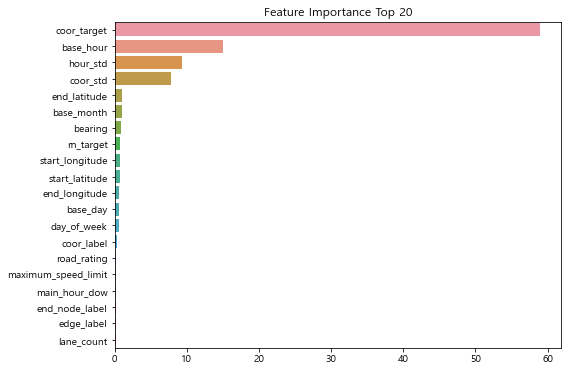

In [18]:
# Catboost의 Feature Importance
ft_importance_values = cat_reg.feature_importances_
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

### Submit

In [81]:
# 사용할 모델로 예측한 뒤 저장한다.
sample['target'] = lgbm_reg.predict(X_test)
date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
sample.to_csv(f'./data/submission/{date}.csv', index=False)

In [82]:
sample

,id,target
0,TEST_000000,23.811073
1,TEST_000001,43.753994
2,TEST_000002,65.666189
3,TEST_000003,38.648504
4,TEST_000004,43.394177
...,...,...
291236,TEST_291236,48.238735
291237,TEST_291237,51.141192
291238,TEST_291238,22.763800
291239,TEST_291239,22.787113
